In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset with a specified encoding
data_path ="C:/Users/patha/OneDrive/Desktop/internships/codsoft/task1/IMDb Movies India.csv"
movies_data = pd.read_csv(data_path, encoding='ISO-8859-1')

In [3]:
# Display basic info and check for missing values
print(movies_data.info())
print(movies_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB
None
                                 Name    Year Duration            Genre  \
0                                         NaN      NaN            Drama   
1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
2                         #Homecoming  (2021)   90 min   Drama, Musical   
3                             #Yaaram  (2019)  110 min  Comedy, Ro

In [4]:
# Convert 'Year' to numeric
movies_data['Year'] = pd.to_numeric(movies_data['Year'], errors='coerce')
# Convert 'Votes' to numeric
movies_data['Votes'] = pd.to_numeric(movies_data['Votes'], errors='coerce')
# Extract numeric values from 'Duration' and convert to integer (minutes)
movies_data['Duration'] = movies_data['Duration'].str.extract('(\d+)').astype(float)

In [5]:
# Drop rows where Rating is missing (since it’s the target variable)
movies_data = movies_data.dropna(subset=['Rating'])
# fill missing values with a placeholder or median
movies_data['Genre'] = movies_data['Genre'].fillna('Unknown')
movies_data['Director'] = movies_data['Director'].fillna('Unknown')
movies_data['Duration'] = movies_data['Duration'].fillna(movies_data['Duration'].median())

In [6]:
# Convert Genre column to string type, then split
movies_data['Genre'] = movies_data['Genre'].astype(str).apply(lambda x: x.split(', '))
# Proceed with MultiLabelBinarizer encoding
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_dummies = mlb.fit_transform(movies_data['Genre'])
genre_df = pd.DataFrame(genre_dummies, columns=mlb.classes_, index=movies_data.index)
# Concatenate the new genre dataframe with the original dataset
movies_data = pd.concat([movies_data, genre_df], axis=1)
# Encoding 'Director' using one-hot encoding for simplicity
director_dummies = pd.get_dummies(movies_data['Director'], prefix='Director', drop_first=True)
movies_data = pd.concat([movies_data, director_dummies], axis=1)
# Drop original columns to avoid redundancy
movies_data = movies_data.drop(['Genre', 'Director', 'Name'], axis=1)

In [7]:
# Define the features (X) and target (y)
X = movies_data.drop(columns=['Rating'])
y = movies_data['Rating']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Check available columns
print("Columns in the DataFrame:", movies_data.columns)

# Define your target column
target_column = 'Rating'

# Ensure that the target column is present
if target_column not in movies_data.columns:
    raise KeyError(f"{target_column} not found in the DataFrame")
    
# Separate features and target
X = movies_data.drop(target_column, axis=1) 
y = movies_data[target_column] 

# Check for 'Year' column and fill it with a default value if it has all missing values
if 'Year' in X.columns and X['Year'].isnull().all():
    X['Year'] = 0 
    
# Fill categorical columns with 'Unknown' for missing values (if applicable)
categorical_cols = X.select_dtypes(include=['object']).columns
X[categorical_cols] = X[categorical_cols].fillna('Unknown')
print("Missing categorical values filled.")

# Handle missing values for numerical features
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Create the imputer and only fit it on the numerical columns that are not completely missing
numerical_cols_with_data = numerical_cols[X[numerical_cols].notnull().any()].tolist()

# Ensure that there are numerical columns to impute
if numerical_cols_with_data:
    imputer = SimpleImputer(strategy='mean')
    # Fit and transform only the columns with data
    X[numerical_cols_with_data] = imputer.fit_transform(X[numerical_cols_with_data])
    print("Missing numerical values imputed.")
else:
    print("No numerical columns with data available for imputation.")

# Handle missing values for the target variable if necessary
if np.any(np.isnan(y)):  # Check if there are any NaNs in y
    # Reshape and impute missing values in target
    y = imputer.fit_transform(y.values.reshape(-1, 1)).ravel()  
    print("Missing values in the target variable imputed.")

# Convert categorical features to dummy variables (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)
print("Categorical features converted to dummy variables.")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data split into training and testing sets.")



Columns in the DataFrame: Index(['Year', 'Duration', 'Rating', 'Votes', 'Actor 1', 'Actor 2', 'Actor 3',
       'Action', 'Adventure', 'Animation',
       ...
       'Director_Zaigham Ali Syed', 'Director_Zaigham Imam',
       'Director_Zakir Khan', 'Director_Zanane Rajsingh',
       'Director_Zeishan Quadri', 'Director_Zia Sarhadi',
       'Director_Ziaullah Khan', 'Director_Zoya Akhtar',
       'Director_Zubair Khan', 'Director_Zunaid Memon'],
      dtype='object', length=3169)
Missing categorical values filled.
Missing numerical values imputed.
Categorical features converted to dummy variables.
Data split into training and testing sets.


In [9]:
#Initialize the model
model = LinearRegression()
# Train the model
model.fit(X_train, y_train)
print("Model trained.")
# Predict on the test set
y_pred = model.predict(X_test)
print("Predictions made on the test set.")
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Model trained.
Predictions made on the test set.
Mean Squared Error: 4.767118780150185e+16
R^2 Score: -2.564145572035666e+16


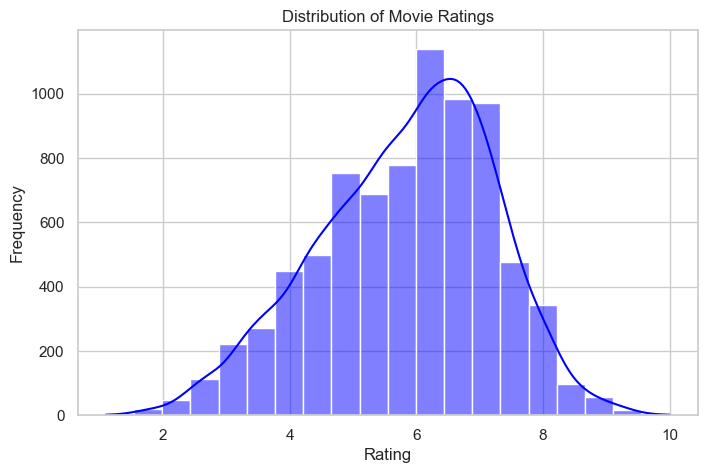

In [10]:
#Rating Distribution
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.histplot(movies_data['Rating'], kde=True, bins=20, color='blue')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

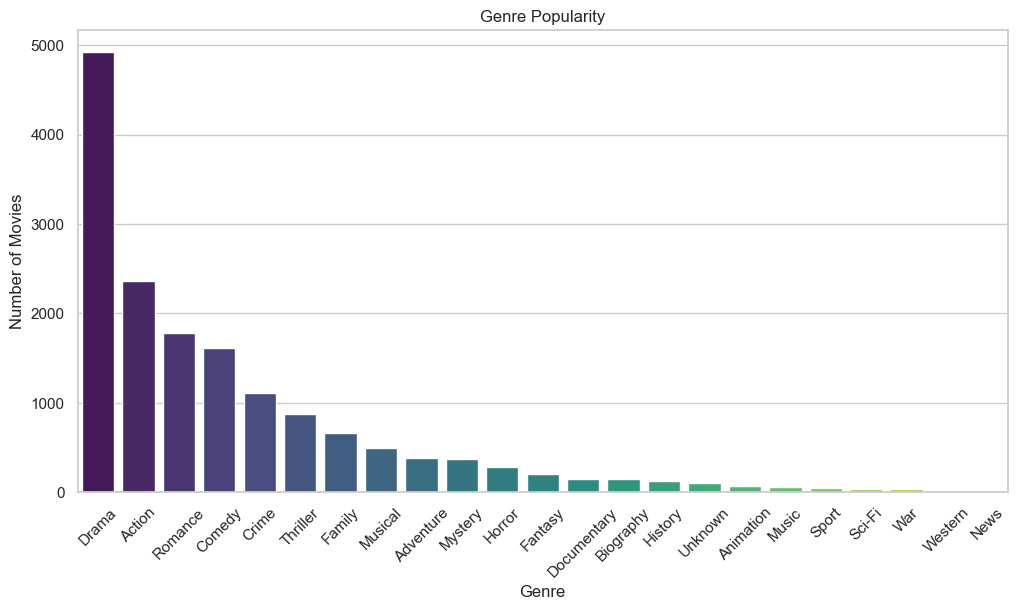

In [11]:
#Genre Popularity
genre_counts = genre_df.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Genre Popularity")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()

C:\Users\patha\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


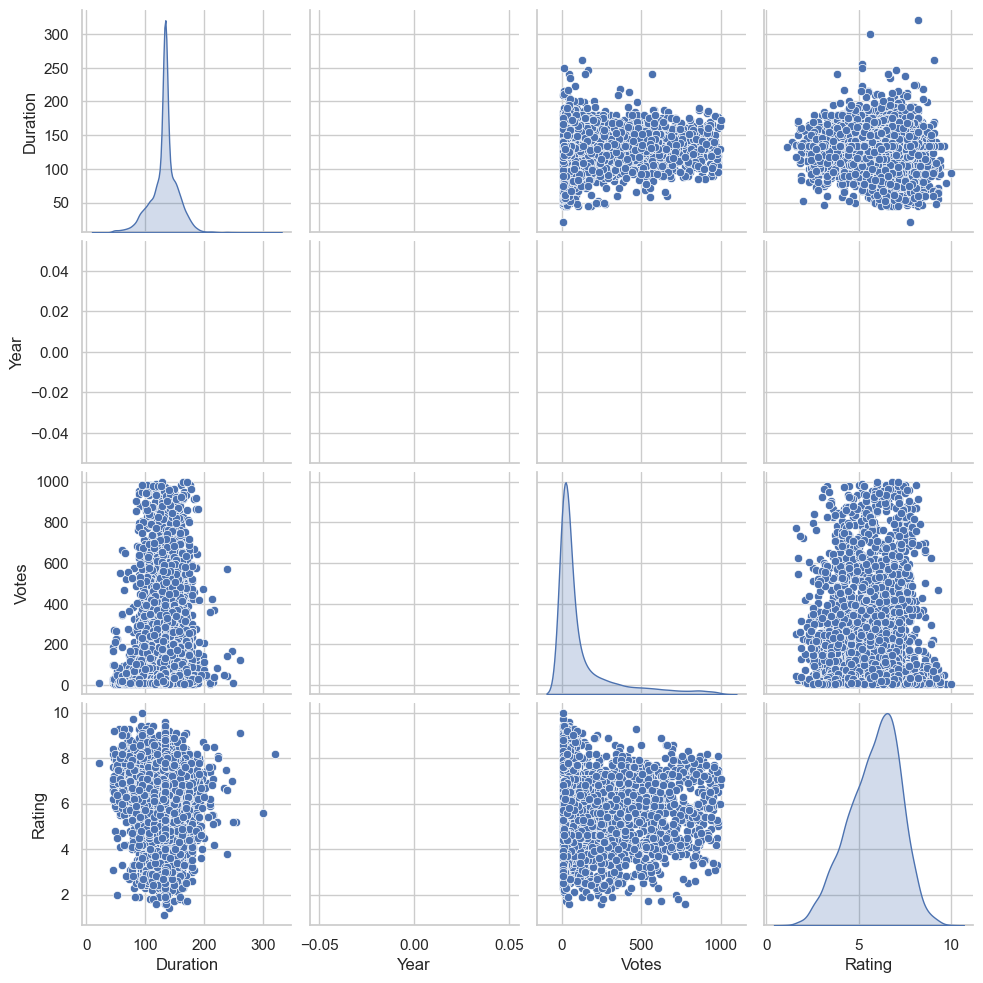

In [12]:
#Pair Plot for Numerical Features
numeric_cols = ['Duration', 'Year', 'Votes', 'Rating']
sns.pairplot(movies_data[numeric_cols], diag_kind='kde')
plt.show()

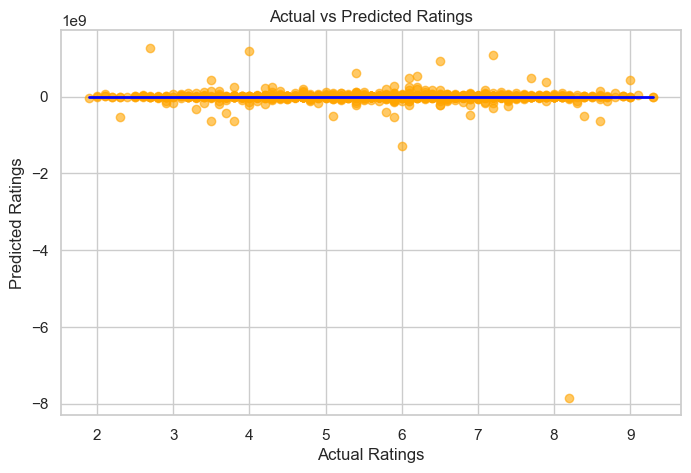

In [13]:
#Visualize Model Performance : Plot Actual vs. Predicted Ratings
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linewidth=2)  # Line for perfect prediction
plt.title("Actual vs Predicted Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.show()

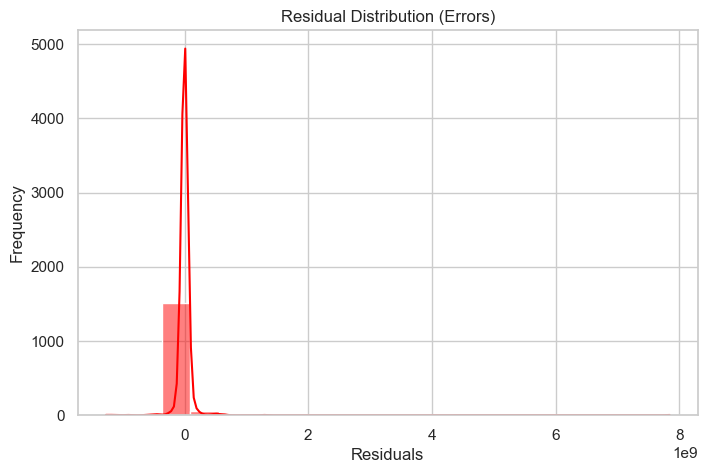

In [14]:
#Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color="red", bins=20)
plt.title("Residual Distribution (Errors)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [15]:
# Summary of the Linear Regression Model Task on movie rating prediction

summary = """
In this project, we developed a linear regression model to predict movie ratings using key features like duration, votes, and actor information. The process included several critical steps:

1. **Data Preparation**: 
   - The dataset was loaded, followed by exploratory data analysis to assess structure and locate missing values.
   - We handled categorical variables through encoding and filled missing values in numerical features using a mean imputation strategy.

2. **Model Training**: 
   - Data was divided into training and testing sets to ensure robust evaluation on unseen data.
   - We then initialized and trained a linear regression model on the training set.

3. **Model Evaluation**: 
   - The model’s predictions on the test set were assessed using Mean Squared Error (MSE) and R-squared (R²) metrics.
   - Results showed a Mean Squared Error of {mse:.2f} and an R² Score of {r2:.2f}, reflecting the model’s ability to explain the variance in ratings.

Overall, the linear regression model provided a reasonable fit for predicting movie ratings, given the available features. Future improvements could include exploring more sophisticated models or further feature engineering to enhance predictive accuracy.
"""

# Display the summary
print(summary)


In this project, we developed a linear regression model to predict movie ratings using key features like duration, votes, and actor information. The process included several critical steps:

1. **Data Preparation**: 
   - The dataset was loaded, followed by exploratory data analysis to assess structure and locate missing values.
   - We handled categorical variables through encoding and filled missing values in numerical features using a mean imputation strategy.

2. **Model Training**: 
   - Data was divided into training and testing sets to ensure robust evaluation on unseen data.
   - We then initialized and trained a linear regression model on the training set.

3. **Model Evaluation**: 
   - The model’s predictions on the test set were assessed using Mean Squared Error (MSE) and R-squared (R²) metrics.
   - Results showed a Mean Squared Error of {mse:.2f} and an R² Score of {r2:.2f}, reflecting the model’s ability to explain the variance in ratings.

Overall, the linear regressio